In [2]:
from rdflib import Graph, ConjunctiveGraph, RDF, RDFS, OWL
from SPARQLWrapper import SPARQLWrapper2
import pandas as pds
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from pandasql import sqldf
import functools

## define function for printing pandas dataframes as markdown

In [3]:
def print_pandas_md(df):
    print(tabulate(df, tablefmt="pipe", headers="keys"))

## define function for converting sparql results to a dataframe

In [4]:
def sparql_to_df(results):
    data = {}
    for variable in results.variables:
        data[variable] = [x.value for x in results.getValues(variable)]
    return pds.DataFrame(data)

## define function to round values in an interval object

In [5]:
def round_interval(interval):
    left_val = round(interval.left)
    right_val = round(interval.right)
    return pds.Interval(left=left_val, right=right_val, closed='left')

## set connection to local triple store

In [6]:
# sparql = SPARQLWrapper2("http://192.168.1.243:7200/repositories/EDR_NO_ES") # local server
sparql = SPARQLWrapper2("http://10.16.128.24:7200/repositories/EDR_NO_ES") # RI server

## define some standard prefixes to use in queries

In [7]:
prefixes = """
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX part_of: <http://purl.obolibrary.org/obo/BFO_0000050>
PREFIX has_part: <http://purl.obolibrary.org/obo/BFO_0000051>
PREFIX material: <http://purl.obolibrary.org/obo/OHD_0000000>
PREFIX tooth: <http://purl.obolibrary.org/obo/FMA_12516>
PREFIX restored_tooh: <http://purl.obolibrary.org/obo/OHD_0000189>
PREFIX surface: <http://purl.obolibrary.org/obo/FMA_no_fmaid_Surface_enamel_of_tooth>
PREFIX restored_surface: <http://purl.obolibrary.org/obo/OHD_0000208>
PREFIX restored_buccal: <http://purl.obolibrary.org/obo/OHD_0000222>
PREFIX restored_distal: <http://purl.obolibrary.org/obo/OHD_0000223>
PREFIX restored_mesial: <http://purl.obolibrary.org/obo/OHD_0000227>
PREFIX restored_labial: <http://purl.obolibrary.org/obo/OHD_0000225>
PREFIX restored_lingual: <http://purl.obolibrary.org/obo/OHD_0000226>
PREFIX restored_incisal: <http://purl.obolibrary.org/obo/OHD_0000224>
PREFIX restored_occlusal: <http://purl.obolibrary.org/obo/OHD_0000228>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX ada_num: <http://purl.obolibrary.org/obo/OHD_0000065>
PREFIX patient: <http://purl.obolibrary.org/obo/OHD_0000012>
PREFIX male_patient: <http://purl.obolibrary.org/obo/OHD_0000054>
PREFIX female_patient: <http://purl.obolibrary.org/obo/OHD_0000049>
PREFIX provider: <http://purl.obolibrary.org/obo/OHD_0000051>
PREFIX procedure: <http://purl.obolibrary.org/obo/OHD_0000002>
PREFIX restoration_procedure: <http://purl.obolibrary.org/obo/OHD_0000004>
PREFIX participates_in: <http://purl.obolibrary.org/obo/BFO_0000056>
PREFIX has_participant: <http://purl.obolibrary.org/obo/BFO_0000057>
PREFIX has_specified_input: <http://purl.obolibrary.org/obo/OBI_0000293>
PREFIX has_specified_output: <http://purl.obolibrary.org/obo/OBI_0000299>
PREFIX sesame: <http://www.openrdf.org/schema/sesame#>
PREFIX birth_date: <http://purl.obolibrary.org/obo/OHD_0000050>
PREFIX npbrn_id: <http://purl.obolibrary.org/obo/OHD_0000273>
PREFIX occur_date: <http://purl.obolibrary.org/obo/OHD_0000015>
PREFIX cdt_code: <http://purl.obolibrary.org/obo/CDT_1000001>
PREFIX is_about: <http://purl.obolibrary.org/obo/IAO_0000136>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX anterior_tooth: <http://purl.obolibrary.org/obo/OHD_0000307>
PREFIX posterior_tooth: <http://purl.obolibrary.org/obo/OHD_0000308>
PREFIX incisor: <http://purl.obolibrary.org/obo/FMA_12823>
PREFIX canine: <http://purl.obolibrary.org/obo/FMA_55636>
PREFIX premolar: <http://purl.obolibrary.org/obo/FMA_55637>
PREFIX molar: <http://purl.obolibrary.org/obo/FMA_55638>
"""

## find teeth (and their surfaces) that underwent a procedure

In [8]:
q = """
%s
select 
    ?patient_id
    ?tooth_id
    ?tooth_num
    ?proc_id
    ?event
    ?event_date
    ?cdt_code
    ?cdt_label
where {
    ?patient_i a patient: .
    ?tooth_i a tooth:;
             part_of: ?patient_i;
             sesame:directType ?tooth_t .
    ?tooth_t ada_num: ?ada_num .
            
    ?proc_i a procedure:;
            sesame:directType ?proc_t;
            has_specified_input: ?tooth_i;
            occur_date: ?occur_date .
    ?proc_t rdfs:label ?proc_label .
    
    ?code_i a cdt_code:;
               	sesame:directType ?code_t;
                is_about: ?proc_i .
    
    ?code_t dc:identifier ?cdt_code;
            obo:cdt_label ?cdt_label .
    
    
    filter (!isblank(?patient_i))
    filter (!isblank(?tooth_i))
    filter (!isblank(?proc_i))
    
    bind(strafter(str(?patient_i), "patient/") as ?patient_id)
    bind(strafter(str(?tooth_i), "tooth/") as ?tooth_id)
    bind(strafter(str(?proc_i), "procedure/") as ?proc_id)
    bind(str(?proc_label) as ?event) # removes the laguage tags
    bind(strafter(?ada_num, "Tooth ") as ?tooth_num)
    bind(strbefore(str(?occur_date), "T") as ?event_date)
    
} 
""" % prefixes
# print(q)

In [9]:
sparql.setQuery(q)
res1 = sparql.query()
tooth_proc_df = sparql_to_df(res1)

In [10]:
tooth_proc_df.drop_duplicates(inplace=True) # make sure there are not duplicates
len(tooth_proc_df)

1645416

## filter out invalid dates and convert datatypes (note: ignore warnings)

In [11]:
tooth_proc_df = tooth_proc_df[tooth_proc_df.event_date.str.startswith('19') | tooth_proc_df.event_date.str.startswith('20')]

In [12]:
tooth_proc_df.event_date = pds.to_datetime(tooth_proc_df.event_date)

In [13]:
tooth_proc_df['patient_id'] = tooth_proc_df['patient_id'].astype(str)
tooth_proc_df['tooth_id'] = tooth_proc_df['tooth_id'].astype(str)
tooth_proc_df['tooth_num'] = tooth_proc_df['tooth_num'].astype(str)
tooth_proc_df['cdt_code'] = tooth_proc_df['cdt_code'].astype(str)
tooth_proc_df['cdt_label'] = tooth_proc_df['cdt_label'].astype(str)

## save local copy of tooth/procedure info

In [15]:
tooth_proc_df.to_csv('triplestore-tooth-procedure-info.tsv', sep='\t')

## find surfaces restored by procedures

In [16]:
q = """
%s
select 
    ?patient_id
    ?tooth_id
    ?tooth_num
    ?proc_id

where {
    ?patient_i a patient: .
    ?tooth_i a tooth:;
             part_of: ?patient_i;
             sesame:directType ?tooth_t .
    ?tooth_t ada_num: ?ada_num .
            
    ?proc_i a procedure:;
            sesame:directType ?proc_t;
            has_specified_input: ?tooth_i;
            occur_date: ?occur_date .
    
    filter (!isblank(?patient_i))
    filter (!isblank(?tooth_i))
    filter (!isblank(?proc_i))
    
    bind(strafter(str(?patient_i), "patient/") as ?patient_id)
    bind(strafter(str(?tooth_i), "tooth/") as ?tooth_id)
    bind(strafter(str(?proc_i), "procedure/") as ?proc_id)
    bind(strafter(?ada_num, "Tooth ") as ?tooth_num)

} 
""" % prefixes
# print(q)

## find tooth type metadata for each tooth

In [19]:
q = """
%s
select distinct
    ?patient_id
    ?tooth_id
    ?tooth_num
    ?anterior
    ?posterior
    ?incisor
    ?canine
    ?premolar
    ?molar
where {
    values ?tooth_type {incisor: canine: premolar: molar:}
    ?patient_i a patient: .
    ?tooth_i a ?tooth_type;
             part_of: ?patient_i;
             sesame:directType ?tooth_t . 
    ?tooth_t ada_num: ?ada_num .
    
    ?proc_i a procedure:;
            has_specified_input: ?tooth_i.
    
    filter (!isblank(?patient_i))
    filter (!isblank(?tooth_i))
    filter (!isblank(?proc_i))
    
    bind (strafter(str(?patient_i), "patient/") as ?patient_id)
    bind (strafter(str(?tooth_i), "tooth/") as ?tooth_id)
    bind (strafter(?ada_num, "Tooth ") as ?tooth_num)
    bind (if(?tooth_type in (incisor:, canine:), 1, 0) as ?anterior)
    bind (if(?tooth_type in (premolar:, molar:), 1, 0) as ?posterior)
    bind (if(?tooth_type = incisor:, 1, 0) as ?incisor)
    bind (if(?tooth_type = canine:, 1, 0) as ?canine)
    bind (if(?tooth_type = premolar:, 1, 0) as ?premolar)
    bind (if(?tooth_type = molar:, 1, 0) as ?molar)
}
""" % prefixes
# print(q)


In [ ]:
sparql.setQuery(q)
res3 = sparql.query()
tooth_type_df = sparql_to_df(res3)

In [ ]:
tooth_type_df.drop_duplicates(inplace=True) # make sure there are no dups
len(tooth_type_df)

## add maxillary maxilla (1-16) mandible (17-32) metadata

In [ ]:
tooth_type_df.tooth_num = tooth_type_df.tooth_num.astype(int) # convert tooth_num to int
tooth_type_df['maxillary'] = tooth_type_df.tooth_num.map(lambda x: 1 if x < 17 else 0)
tooth_type_df['mandibular'] = tooth_type_df.tooth_num.map(lambda x: 1 if x > 16 else 0)

## add left/right metadata

In [ ]:
temp = tooth_type_df.copy()

In [ ]:
tooth_type_df['left'] = tooth_type_df.tooth_num.map(lambda x: 1 if x > 8 and x < 25 else 0)
tooth_type_df['right'] = tooth_type_df.tooth_num.map(lambda x: 1 if x < 9 or x > 24 else 0)

## save local copy of tooth type metadata

In [ ]:
tooth_type_df.to_csv('triplestore-tooth-type-info.tsv', sep='\t')

## find total number of teeth by tooth type that underwent a procedure

In [67]:
toot_count_df = tooth_proc_df[['tooth_num']].copy()
toot_count_df.tooth_num = toot_count_df.tooth_num.astype(int)
tooth_count_query = """
select 
    tooth_num as [Tooth Number], count(*) as [Number of Teeth]
from
    toot_count_df
group by
    tooth_num
order by
    tooth_num
"""
temp_df = sqldf(tooth_count_query)

In [91]:
temp_df.set_index('Tooth Number', inplace=True) # use tooth numbers for the index

/Users/widuncan/repos/git/NDPBRN/src/analysis/.env/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator


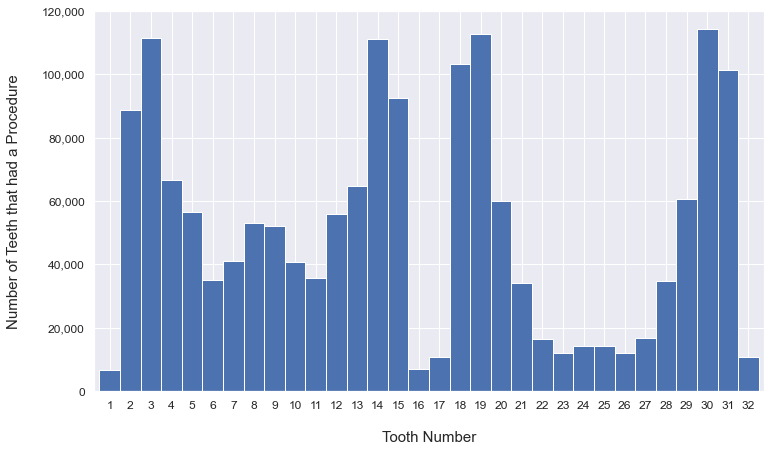

In [93]:
%matplotlib inline
colors = ['#4c72b0']
sns.set_palette(colors)

# draw bar chart showing the number of procedures performed on each tooth (number)
ax = temp_df.plot.bar(figsize=(12,7), width=1.0) 

# rotate the ticks on the x axis
plt.xticks(rotation=0)

# configure labels
# note the use of '\n' to create space between ticks and labels
ax.set_xlabel("\nTooth Number", fontsize=15)
ax.set_ylabel("Number of Teeth that had a Procedure\n", fontsize=15)
ax.tick_params(labelsize='large')


ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()]) # put commas in y-ticks
ax.get_legend().remove() # remove legend
plt.savefig("figures/tooth-count-per-tooth.png", dpi=600, bbox_inches="tight")
plt.show()

In [120]:
tooth_proc_df[tooth_proc_df.patient_id == "A_1_1_248"]

,patient_id,tooth_id,tooth_num,event,event_date,cdt_code,cdt_label,m,o,d,b,f,l,i,num_surfaces


In [118]:
tooth_proc_df.head()

,patient_id,tooth_id,tooth_num,event,event_date,cdt_code,cdt_label,m,o,d,b,f,l,i,num_surfaces
0,A_1_1_17,A_1_1_17_7,7,resin filling restoration procedure,2011-04-23,D2331,"resin-based composite - two surfaces, anterior",1,0,0,0,0,0,1,2
1,A_1_1_22,A_1_1_22_7,7,resin filling restoration procedure,2004-07-11,D2330,"resin-based composite - one surface, anterior",0,0,0,0,1,0,0,1
2,A_1_1_22,A_1_1_22_7,7,resin filling restoration procedure,2011-12-03,D2330,"resin-based composite - one surface, anterior",0,0,1,0,0,0,0,1
3,A_1_1_342,A_1_1_342_7,7,ceramic crown restoration procedure,2013-03-18,D2740,crown - porcelain/ceramic substrate,0,0,0,0,0,0,0,0
4,A_1_1_412,A_1_1_412_7,7,resin filling restoration procedure,2012-01-22,D2331,"resin-based composite - two surfaces, anterior",1,0,0,0,0,1,0,2
